In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mp
import sklearn
from IPython.display import Image

from sklearn.neighbors import KNeighborsClassifier 
import sklearn.datasets as datasets
%matplotlib inline

# $k$-Nearest Neighbors

Today we'll expand our repetoire of classification techniques.

In so doing we'll look at a first example of a new kind of model: nonparametric.

## Parametric vs. Nonparametric Models

There are many ways to define models (whether supervised or unsupervised).

However a key distinction is this:  does the model have a fixed number of parameters, or does the number of parameters grow with the training data?

If the model has a __fixed number__ of parameters, it is called __parametric.__

If the number of parameters grows with the data, the model is called __nonparametric.__

Parametric models have 
* the advantage of often being faster to use, 
* but the disadvantage of making strong assumptions about the nature of data distributions.

Nonparametric models are
* more flexible,
* but can be computationally intractable for large datasets.

The classic example of a nonparametric classifier is called __$k$-Nearest Neighbors.__

In [2]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

## $k$-Nearest Neighbors

> When I see a bird that walks like a duck and swims like a duck and quacks like a duck, I call that bird a duck.

--James Whitcomb Riley (1849 - 1916)

<center>

<img src="figs/L15-duck.jpg" width="100px">

</center>

Like any classifier, $k$-Nearest Neighbors is trained by providing it a set of labeled data.

However, at training time, the classifier does very little.   It just stores away the training data.

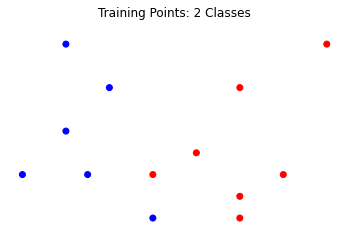

In [3]:
demo_y = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
demo_X = np.array([[-3,1], [-2, 4], [-2, 2], [-1.5, 1], [-1, 3], [0, 0], [1, 1.5], [2, 0.5], [2, 3], [2, 0], [3, 1], [4, 4], [0, 1]])
test_X = [-0.3, 0.7]
#
plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
plt.axis('equal')
plt.axis('off')
plt.title('Training Points: 2 Classes');

The idea of the $k$-Nearest Neighbors classifier is that, at test time, it simply "looks at" the $k$ points in the training set that are nearest to the test input $x$, and makes a decision based on the labels on those points.

By "nearest" we usually mean in Euclidean distance.

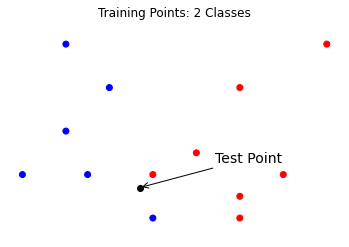

In [4]:
plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
plt.plot(test_X[0], test_X[1], 'ok')
plt.annotate('Test Point', test_X, [75, 25], 
             textcoords = 'offset points', fontsize = 14, 
             arrowprops = {'arrowstyle': '->'})
plt.axis('equal')
plt.axis('off')
plt.title('Training Points: 2 Classes');

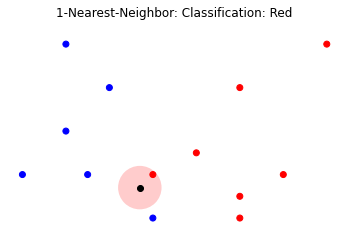

In [5]:
plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
plt.plot(test_X[0], test_X[1], 'ok')
ax=plt.gcf().gca()
circle = mp.patches.Circle(test_X, 0.5, facecolor = 'red', alpha = 0.2)
plt.axis('equal')
plt.axis('off')
ax.add_artist(circle)
plt.title('1-Nearest-Neighbor: Classification: Red');

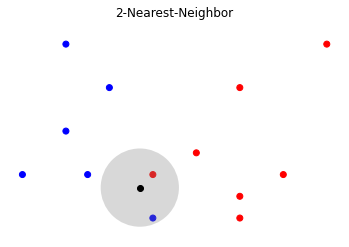

In [6]:
plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
test_X = [-0.3, 0.7]
plt.plot(test_X[0], test_X[1], 'ok')
ax=plt.gcf().gca()
    #ellipse = mp.patches.Ellipse(gmm.means_[clus], 3 * e[0], 3 * e[1], angle, color = 'r')
circle = mp.patches.Circle(test_X, 0.9, facecolor = 'gray', alpha = 0.3)
plt.axis('equal')
plt.axis('off')
ax.add_artist(circle)
plt.title('2-Nearest-Neighbor');

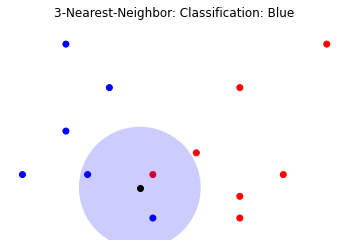

In [7]:
plt.figure()
ax=plt.gcf().gca()
    #ellipse = mp.patches.Ellipse(gmm.means_[clus], 3 * e[0], 3 * e[1], angle, color = 'r')
circle = mp.patches.Circle(test_X, 1.4, facecolor = 'blue', alpha = 0.2)
ax.add_artist(circle)
plt.scatter(demo_X[:,0], demo_X[:,1], c=demo_y, cmap=cmap_bold)
test_X = [-0.3, 0.7]
plt.plot(test_X[0], test_X[1], 'ok')
plt.axis('equal')
plt.axis('off')
plt.title('3-Nearest-Neighbor: Classification: Blue');

Note that $k$-Nearest Neighbors can do either __hard__ or __soft__ classification.

As a hard classifier, it returns the majority vote of the labels on the $k$ Nearest Neighbors.

Which may be indeterminate, as above.

It is also reasonable to weight the votes of neighborhood points according to their distance from $x$.

As a soft classifier it returns:
    
$$ p(x = c\,|\,\mathbf{x}, k) = \frac{\text{number of points in neighborhood with label } c}{k} $$

## Model Selection for $k$-NN

Each value of $k$ results in a different model.

The complexity of the resulting model is therefore controlled by the hyperparameter $k$.

Hence we will want to select $k$ using held-out data to avoid overfitting.

Consider this dataset where items fall into three classes:

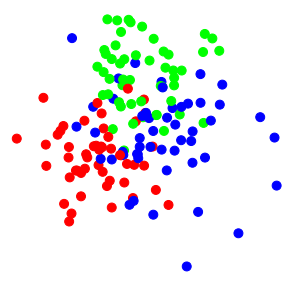

In [8]:
import sklearn.datasets as sk_data
X, y = sk_data.make_blobs(n_samples=150, 
                          centers=[[-2, 0],[1, 5], [2.5, 1.5]],
                          cluster_std = [2, 2, 3],
                          n_features=2,
                          center_box=(-10.0, 10.0),random_state=0)
plt.figure(figsize = (5,5))
plt.axis('equal')
plt.axis('off')
plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold, s = 80);

Let's observe how the complexity of the resulting model changes as we vary $k$.

We'll do this by plotting the __decision regions__.   These show how the method would classify each potential test point in the space.

In [9]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .1  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

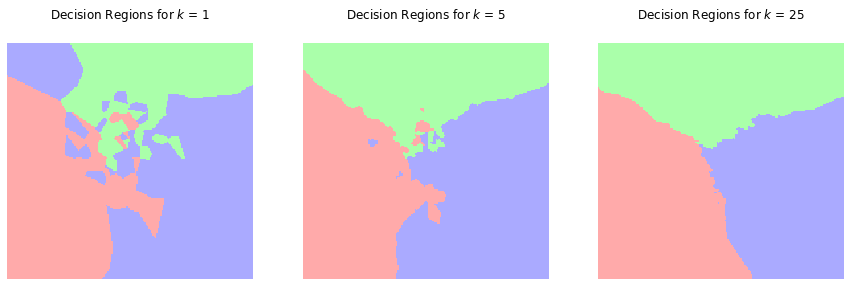

In [10]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, k in enumerate([1, 5, 25]):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X, y)
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[i].pcolormesh(xx, yy, Z, cmap = cmap_light, shading = 'auto')
    axs[i].axis('equal')
    axs[i].axis('off')
    axs[i].set_title(f'Decision Regions for $k$ = {k}');

Notice how increasing $k$ results in smoother decision boundaries.

These are more likely to show good generalization ability.

## Challenges for $k$-NN

Working with a $k$-NN classifier can involve some challenges.

1. First and foremost, the computational cost of classification grows with the size of the training data. (Why?) While certain data structures may help, essentially the classification time grows linearly with the data set size.

Note the tradeoff here: the training step is trivial, but the classification step can be prohibitively expensive.

2. Second, since Euclidean distance is the most common distance function used, data scaling is important.   

As previously discussed, features should be scaled to prevent distance measures from being dominated by a small subset of features.

<div style = "float: left; width: 55%;">
    
3. Third concerns the __curse of dimensionality.__

If training data lives in a high dimensional space, Euclidean distance measures become less effective.

This is subtle but important, so we will now look at the curse of dimensionality more closely.
    
</div>
    
<img src="figs/L15-curse-frankenstein-edited.jpeg" alt="Figure" width="20%" float = "right">

### The Curse of Dimensionality

The Curse of Dimensionality is a somewhat tongue in cheek term for serious problems that arise when we use geometric algorithms in high dimensions.

There are various aspects of the Curse that affect $k$-NN.

__1. Points are far apart in high dimension.__

$k$-NN relies on there being one or more "close" points to the test point $x$.   

In other words, we need the training data to be relatively dense, so there are "close" points everywhere.

Unfortunately, the amount of space we work in grows exponentially with the dimension $d$.

So the amount of data we need to maintain a given density also grows exponentially with dimension $d$.

Hence, points in high-dimensional spaces tend not to be close to one another at all.

One very intuitive way to think about it is this:

In order for two points to be close in $\mathbb{R}^d$, they must be close in __each__ of the $d$ dimensions.

As the number of dimensions grows, it becomes harder and harder for a pair of points to be close in __each__ dimension.

__2. Points tend to all be at similar distances in high dimension.__

This one is a little harder to visualize.  We'll use formulas instead to guide us.

Let's say points are uniformly distributed in space, so that number of points in a region is proportional to the region's volume.  

How does volume relate to distance as dimension $d$ grows?

Consider you are at some point in space (say, the test point $x$), and you want to know how many points are within a unit distance from you.

This is proportional to the volume of a hypersphere with radius 1.

Now, the volume of a hypersphere is $k_d \,r^d$.  

For each $d$ there is a different $k_d$.  
* For $d = 2$, $k_d$ is $4\pi$, and 
* for $d = 3$, $k_d$ is 4/3 $\pi$, 
* etc.

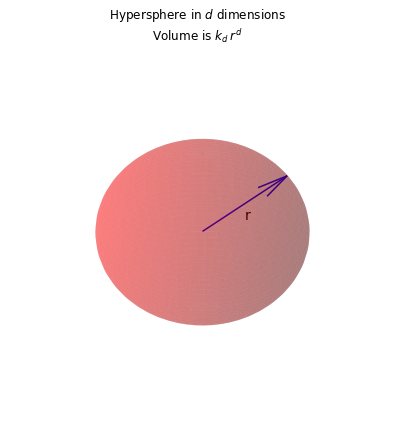

In [11]:
ax = plt.figure(figsize = (7,7)).add_subplot(projection = '3d')
# coordinates of sphere surface
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
#
ax.plot_surface(x, y, z, color='r', alpha = 0.3)
s3 = 1/np.sqrt(3)
ax.quiver(0, 0, 0, s3, s3, s3, color = 'b')
ax.text(s3/2, s3/2, s3/2-0.2, 'r', size = 14)
ax.set_axis_off()
plt.title('Hypersphere in $d$ dimensions\nVolume is $k_d \,r^d$');

Let's also ask how many points are within a slightly smaller distance, let's say 0.99.  

The new distance can be thought of as $1 - \epsilon$ for some small $\epsilon$.

The number of points then of course is proprtional to $k_d (1-\epsilon)^d$

Now, what is the fraction $f_d$ of all the points that are within a unit distance, but __not__ within a distance of 0.99?

(That is, not within the the hypersphere with radius $1-\epsilon$)?

This is 
$$ f_d = \frac{k_d 1^d - k_d (1-\epsilon)^d}{k^d 1^d} $$

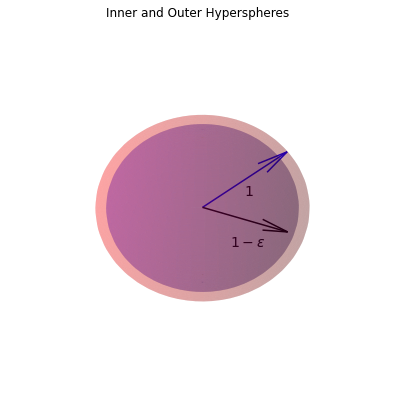

In [12]:
ax = plt.figure(figsize = (7,7)).add_subplot(projection = '3d')
# coordinates of sphere surface
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
#
ax.plot_surface(x, y, z, color='r', alpha = 0.2)
s3 = 1/np.sqrt(3)
ax.quiver(0, 0, 0, s3, s3, s3, color = 'b')
ax.text(s3/2, s3/2, s3/2-0.2, '1', size = 14)
#
eps = 0.9
#
ax.plot_surface(eps * x, eps * y, eps * z, color='b', alpha = 0.2)
ax.quiver(0, 0, 0, eps, 0, 0, color = 'k')
ax.text(1/2-0.2, 0, -0.4, r'$1-\epsilon$', size = 14)
ax.set_axis_off()
plt.title('Inner and Outer Hyperspheres');

Now, $(1-\epsilon)^d$ goes to 0 as $d \rightarrow \infty$.

So, $f_d$ goes to 1 as $d \rightarrow \infty$.

Which means: in the limit of high $d$, all of the points that are __within__ 1 unit of our location, are almost __exactly__ 1 unit from our location!

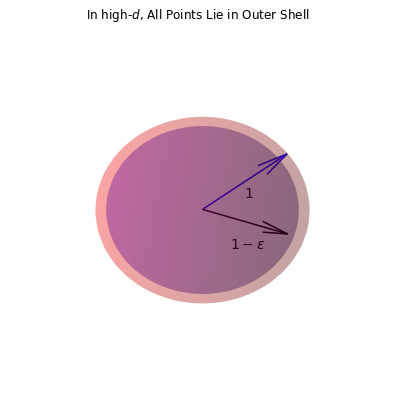

In [13]:
ax = plt.figure(figsize = (7,7)).add_subplot(projection = '3d')
# coordinates of sphere surface
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
#
ax.plot_surface(x, y, z, color='r', alpha = 0.2)
s3 = 1/np.sqrt(3)
ax.quiver(0, 0, 0, s3, s3, s3, color = 'b')
ax.text(s3/2, s3/2, s3/2-0.2, '1', size = 14)
#
eps = 0.9
#
ax.plot_surface(eps * x, eps * y, eps * z, color='b', alpha = 0.2)
ax.quiver(0, 0, 0, eps, 0, 0, color = 'k')
ax.text(1/2-0.2, 0, -0.4, r'$1-\epsilon$', size = 14)
ax.set_axis_off()
plt.title('In high-$d$, All Points Lie in Outer Shell');

```{note}
The following example is based on _Data Science from Scratch,_ Joel Grus, Second Edition, Chapter 12.  
```

Let's demonstrate this effect in practice.

What we will do is create 100 points, scattered at random within a $d$-dimensional space.

We will look at two quantities:
* The __minimum__ distance between any two points, and
* The __average__ distance between any two points.

as we vary $d$.

In [14]:
import sklearn.metrics as metrics

nsamples = 1000
unif_X = np.random.default_rng().uniform(0, 1, nsamples).reshape(-1, 1)
euclidean_dists = metrics.euclidean_distances(unif_X)
# extract the values above the diagonal
dists = euclidean_dists[np.triu_indices(nsamples, 1)]
mean_dists = [np.mean(dists)]
min_dists = [np.min(dists)]
for d in range(2, 101):
    unif_X = np.column_stack([unif_X, np.random.default_rng().uniform(0, 1, nsamples)])
    euclidean_dists = metrics.euclidean_distances(unif_X)
    dists = euclidean_dists[np.triu_indices(nsamples, 1)]
    mean_dists.append(np.mean(dists))
    min_dists.append(np.min(dists))

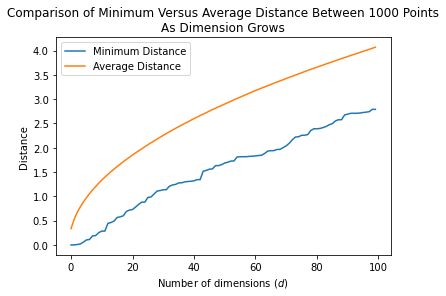

In [15]:
plt.plot(min_dists, label = "Minimum Distance")
plt.plot(mean_dists, label = "Average Distance")
plt.xlabel(r'Number of dimensions ($d$)')
plt.ylabel('Distance')
plt.legend(loc = 'best')
plt.title(f'Comparison of Minimum Versus Average Distance Between {nsamples} Points\nAs Dimension Grows');

The average distance between points grows, but it seems that the minimum distance between points grows about as fast.

So the ratio of the minimum distance to the average distance grows as well!

Let's look at that ratio:

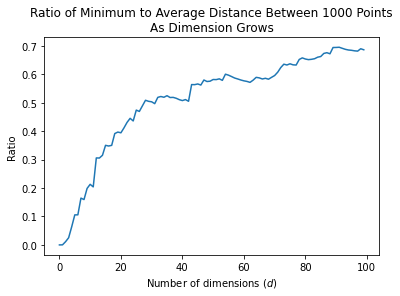

In [16]:
plt.plot([a/b for a, b in zip(min_dists, mean_dists)])
plt.xlabel(r'Number of dimensions ($d$)')
plt.ylabel('Ratio')
plt.title(f'Ratio of Minimum to Average Distance Between {nsamples} Points\nAs Dimension Grows');

This shows that, for any test point $x$, the distance to the __closest__ point to $x$, relatively speaking, gets closer and closer to the __average__ distance between points.

Of course, if we used a point at the average distance for classifying $x$, we'd get a very poor classifier.

__Implications of the Curse.__

For $k$-means, the Curse of Dimensionality means that in high dimension, most points are nearly the same distance from the test point.

This makes $k$-means ineffective:  it cannot reliably tell which are the $k$ nearest neighbors, and its performance degrades.

__What Can be Done?__

The problem is that you simply cannot have enough data to do a good job using $k$-NN in high dimensions.

If you must use $k$-NN for your task, the only option may be to __reduce__ the dimension of your data.

Surprisingly, this can often be done at little cost in accuracy.

We will discuss dimensionality reduction techniques at length later in the course.

## In Practice

Next we'll look at two classification methods in practice: 

* Decision Trees, and 
* k-Nearest Neighbors.

To compare these methods, the question arises:
    
### How do we evaluate a classifier?

In the simple case of a binary classifier, we can call one class the 'Positive' class and one the 'Negative' class.

The most basic measure of success for a classifer is __accuracy__: what fraction of test points are correctly classified?

Of course, accuracy is important, but it can be too simplistic at times.

For example, let's say we have a dataset showing __class imbalance__: for example 90% of the data are the Positive class and 10% are the Negative class.

For this dataset, consider a classifier that always predicts 'Positive'.   Its accuracy is 90%, but it is a very 'stupid' classifier!  (ie, it could be one line of code: `print(Positive)`!)

A better way to measure the classifier's performance is using a Confusion Matrix:

<img src="figs/L15-confusion-matrix.png" alt="Figure" width="30%" float = "right">

Diagonal elements represent successes, and off diagonals represent errors.

Using the confusion matrix we can define some more useful measures:
   * __Recall__ - defined as the fraction of actual positives correctly classified:  
       * TP/(TP + FN)
   * __Precision__ - defined as the fraction of classified positives correctly classified: 
       * TP/(TP + FP)

### Evaluating $k$- Nearest Neighbors and Decision Trees

First we'll generate some synthetic data to work with.

In [17]:
X, y = datasets.make_circles(noise=.1, factor=.5, random_state=1)
print('Shape of data: {}'.format(X.shape))
print('Unique labels: {}'.format(np.unique(y)))

Shape of data: (100, 2)
Unique labels: [0 1]


Here is what the data looks like:

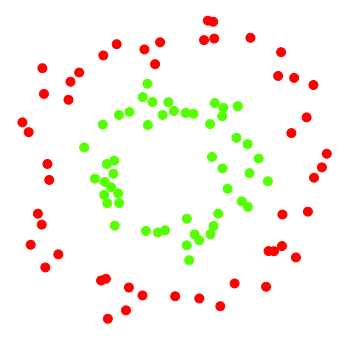

In [18]:
plt.figure(figsize = (6,6))
plt.prism()  # this sets a nice color map
plt.scatter(X[:, 0], X[:, 1], c=y, s = 80)
plt.axis('off')
plt.axis('equal');

Recall that we always want to test on data separate from our training data.

For now, we will something very simple: take the first 50 examples for training and the rest for testing.   (Later we will do this a better way.)

In [19]:
X_train = X[:50]
y_train = y[:50]
X_test = X[50:]
y_test = y[50:]

In [20]:
fig_size = (12, 5)

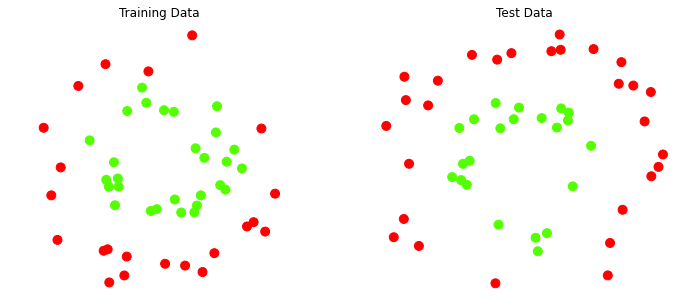

In [21]:
plt.figure(figsize = fig_size)
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 80)
plt.axis('equal')
plt.axis('off')
plt.title('Training Data')

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, s = 80)
plt.title('Test Data')
plt.axis('equal')
plt.axis('off');

For our first example, we will classify the points (in the two classes) using a k-nn classifier.

We will specify that $k=5$, i.e., we will classify based on the majority vote of the 5 nearest neighbors.

In [22]:
k = 5
knn5 = KNeighborsClassifier(n_neighbors = k)    

In the context of supervised learning, the `scikit-learn` `fit()` function corresponds to __training__ and the `predict()` function corresponds to __testing.__

In [23]:
knn5.fit(X_train,y_train)
print(f'Accuracy on test data: {knn5.score(X_test, y_test)}')

Accuracy on test data: 0.72


Accuracy of 72% sounds good -- but let's dig deeper. 

We'll call the red points the Positive class and the green points the Negative class.

Here is the confusion matrix:

In [24]:
y_pred_test = knn5.predict(X_test)
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_test), 
             columns = ['Predicted +', 'Predicted -'], 
             index = ['Actual +', 'Actual -'])

,Predicted +,Predicted -
Actual +,14,14
Actual -,0,22


Looks like the classifier is getting all of the Negative class correct, but only achieving accuracy of 50% on the Positive class.

That is, its __precision__ is 100%, but its __recall__ is only 50%.

Let's visualize the results.

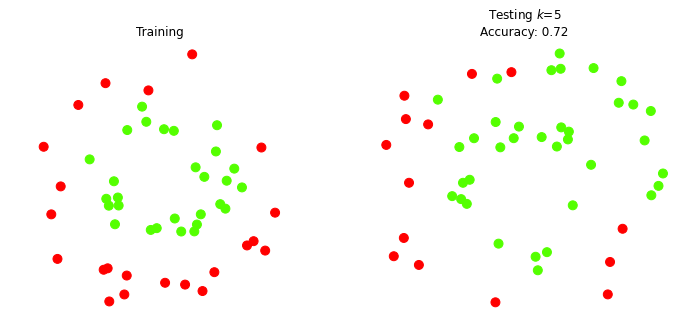

In [25]:
k = 5

plt.figure(figsize = fig_size)
plt.subplot(1, 2, 1)

plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 80)
plt.axis('equal')
plt.title('Training')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_pred_test, s = 80)
plt.title(f'Testing $k$={k}\nAccuracy: {knn5.score(X_test, y_test)}')
plt.axis('off')
plt.axis('equal');

Indeed, the Positive (red) points in the upper half of the test data are all classified incorrectly. 

Let's look at one of the points that the classifier got wrong:

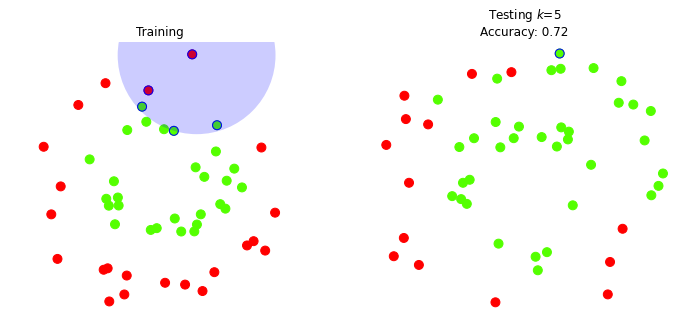

In [26]:
k=5 
test_point = np.argmax(X_test[:,1])
neighbors = knn5.kneighbors([X_test[test_point]])[1]

plt.figure(figsize = fig_size)
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 80)
plt.scatter(X_train[neighbors,0], X_train[neighbors,1],
            c = y_train[neighbors], marker='o', 
            facecolors='none', edgecolors='b', s = 80)
radius = np.max(metrics.euclidean_distances(X_test[test_point].reshape(1, -1), X_train[neighbors][0]))
ax = plt.gcf().gca()
circle = mp.patches.Circle(X_test[test_point], radius, facecolor = 'blue', alpha = 0.2)
ax.add_artist(circle)
plt.axis('equal')
plt.axis('off')
plt.title(r'Training')

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_pred_test, s = 80)
plt.scatter(X_test[test_point,0], X_test[test_point,1], marker='o', 
            facecolors='none', edgecolors='b', s = 80)
plt.title('Testing $k$={}\nAccuracy: {}'.format(k,knn5.score(X_test, y_test)))
plt.axis('equal')
plt.axis('off');

For comparison purposes, let's try $k$ = 3.

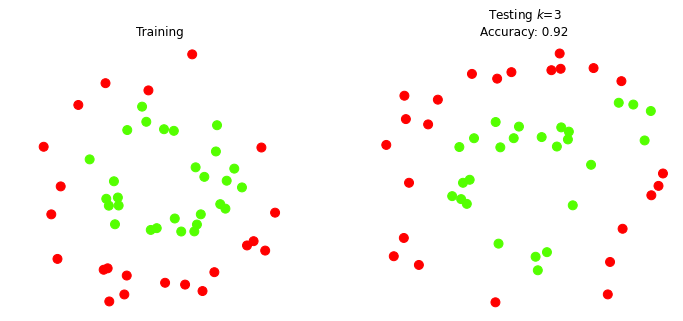

In [27]:
k = 3
knn3 = KNeighborsClassifier(n_neighbors=k)    
knn3.fit(X_train,y_train)
y_pred_test = knn3.predict(X_test)

plt.figure(figsize = fig_size)
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s = 80)
plt.axis('equal')
plt.axis('off')
plt.title(r'Training')

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, s = 80)
plt.title(f'Testing $k$={k}\nAccuracy: {knn3.score(X_test, y_test)}')
plt.axis('off')
plt.axis('equal');

And let's look at the same individual point as before:

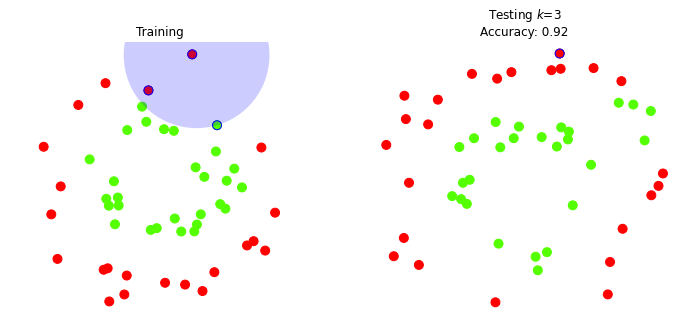

In [28]:
k = 3
test_point = np.argmax(X_test[:,1])
X_test[test_point]
neighbors = knn3.kneighbors([X_test[test_point]])[1]

plt.figure(figsize = fig_size)
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s = 80)
plt.scatter(X_train[neighbors, 0], X_train[neighbors, 1], marker = 'o', 
            facecolors = 'none', edgecolors = 'b', s = 80)
radius = np.max(metrics.euclidean_distances(X_test[test_point].reshape(1, -1), 
                                            X_train[neighbors][0]))
ax = plt.gcf().gca()
circle = mp.patches.Circle(X_test[test_point], radius, facecolor = 'blue', alpha = 0.2)
ax.add_artist(circle)
plt.axis('equal')
plt.axis('off')
plt.title(r'Training')
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_pred_test, s = 80)
plt.scatter(X_test[test_point,0], X_test[test_point,1], marker = 'o', 
            facecolors = 'none', edgecolors = 'b', s = 80)
plt.title(f'Testing $k$={k}\nAccuracy: {knn3.score(X_test, y_test)}')
plt.axis('off')
plt.axis('equal');

So how confident can we be that the test accuracy is 98% in general?

What we really need to do is consider __many__ different train/test splits.

Thus, the proper way to evaluate generalization ability (accuracy on the test data) is:
    
1. Form a random train/test split
2. Train the classifier on the training split
3. Test the classifier on the testing split
4. Accumulate statistics
5. Repeat from 1. until enough statistics have been collected.

In [29]:
import sklearn.model_selection as model_selection

nreps = 50
kvals = range(1, 10)
acc = []
np.random.seed(4)
for k in kvals:
    test_rep = []
    train_rep = []
    for i in range(nreps):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                            y, 
                                                                            test_size = 0.5)
        knn = KNeighborsClassifier(n_neighbors = k)    
        knn.fit(X_train, y_train)
        train_rep.append(knn.score(X_train, y_train))
        test_rep.append(knn.score(X_test, y_test))
    acc.append([np.mean(np.array(test_rep)), np.mean(np.array(train_rep))])
accy = np.array(acc)

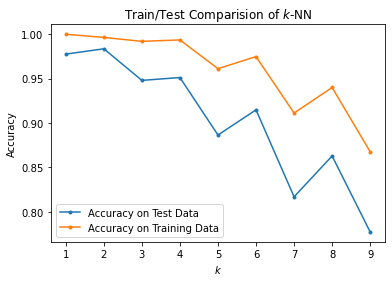

In [30]:
plt.plot(kvals, accy[:, 0], '.-', label = 'Accuracy on Test Data')
plt.plot(kvals, accy[:, 1], '.-', label = 'Accuracy on Training Data')
plt.xlabel(r'$k$')
plt.ylabel('Accuracy')
plt.title('Train/Test Comparision of $k$-NN')
plt.legend(loc = 'best');

Based on the generalization error (ie, accuracy on test (held-out) data), it looks like $k = 2$ is the best choice. 

Here is the __decision boundary__ for $k$-NN with $k = 2$.

In [31]:
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
plot_step = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

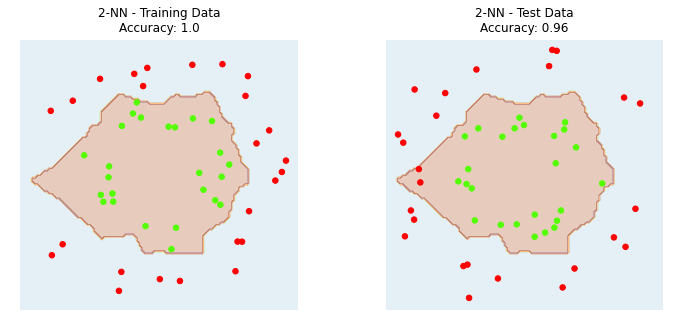

In [32]:
np.random.seed(1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5)

k = 2
knn = KNeighborsClassifier(n_neighbors = k)  
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize = fig_size)
plt.subplot(1, 2, 1)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'{k}-NN - Training Data\nAccuracy: {knn.score(X_train, y_train)}');

plt.subplot(1, 2, 2)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=30)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'{k}-NN - Test Data\nAccuracy: {knn.score(X_test, y_test)}');

## Decision Tree

Next, we'll use a decision tree on the same data set.

In [33]:
import sklearn.tree as tree
dtc = tree.DecisionTreeClassifier(max_leaf_nodes = 5)

dtc.fit(X_train,y_train)
y_pred_test = dtc.predict(X_test)
print('DT accuracy on test data: ', dtc.score(X_test, y_test))
y_pred_train = dtc.predict(X_train)
print('DT accuracy on training data: ', dtc.score(X_train, y_train))

DT accuracy on test data:  0.94
DT accuracy on training data:  0.98


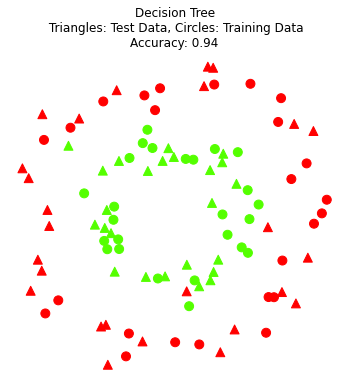

In [34]:
plt.figure(figsize = (6, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, marker='^', s=80)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=80)
plt.axis('equal')
plt.axis('off')
plt.title(F'Decision Tree\n Triangles: Test Data, Circles: Training Data\nAccuracy: {dtc.score(X_test, y_test)}');

Let's visualize the __decision boundary__ of the Decision Tree.

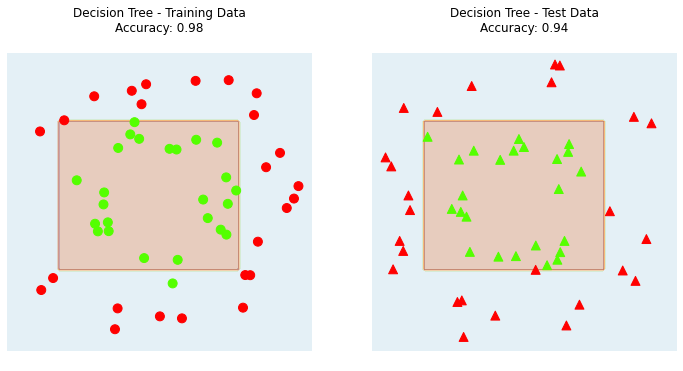

In [35]:
Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 80)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'Decision Tree - Training Data\nAccuracy: {dtc.score(X_train, y_train)}');

plt.subplot(1, 2, 2)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_pred_test, marker = '^', s = 80)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'Decision Tree - Test Data\nAccuracy: {dtc.score(X_test, y_test)}');

## Comparing $k$-NN and Decision Tree

It appears that $k$-NN and a Decision Tree have approximately comparable performance on this dataset.

However - there is a difference in __interpretability.__

Interpretability is a big deal!  It means the ability to __explain__ why the classifier made the decision it did.

It can be relatively difficult to __understand__ why $k$-NN is making a specific prediction.  It depends on the data in the neighborhood of the test point.

On the other hand, the Decision Tree can be easily understood.

We sometimes use the terms "black box" for an uninterpretable classifier like $k$-NN, and "white box" for an interpretable classifier like DT.

Let's see an example of the interpretability of the Decision Tree:

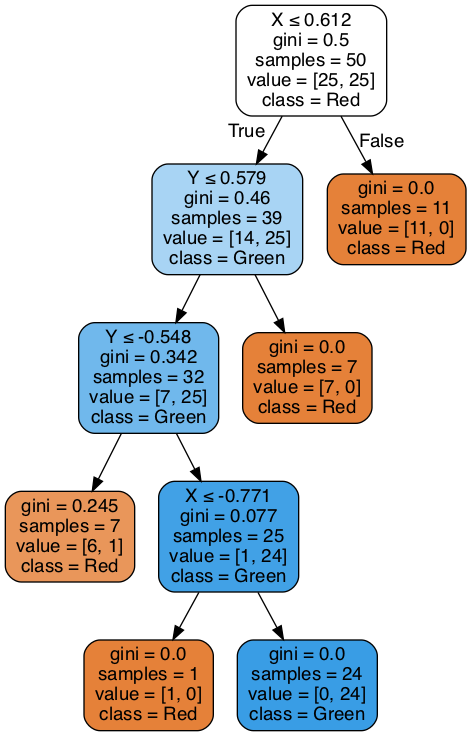

In [36]:
dot_data = tree.export_graphviz(dtc, out_file=None,
                         feature_names=['X','Y'],
                         class_names=['Red','Green'],
                         filled=True, rounded=True,  
                         special_characters=True) 
import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data) 
# graph.write_pdf("dt.pdf") 
Image(graph.create_png())

## Real Data

To explore a few more issues, we'll now turn to some famous datasets that have been extensively studied in the past.

### The Iris Dataset

The Iris dataset is a famous dataset used by Ronald Fisher in a classic 1936 paper on classification.

<center>

<img src="figs/R._A._Fisher.png" alt="Figure" width="35%">
    
R. A. Fisher

</center>

By http://www.swlearning.com/quant/kohler/stat/biographical_sketches/Fisher_3.jpeg, Public Domain, https://commons.wikimedia.org/w/index.php?curid=4233489

Quoting from Wikipedia:

>The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

<center>
    
<img src="figs/Iris_setosa.png" alt="I. setosa" width="200px" float = "left">
    
I. setosa
    
<img src="figs/Iris_versicolor.png" alt="I. versicolor" width="200px" float = "left">
    
I. versicolor
    
<img src="figs/Iris_virginica.png" alt="I. virginica" width="200px" float = "left">
    
I. virginica
    
</center>

In [37]:
iris = datasets.load_iris()

In [38]:
X = iris.data
y = iris.target
ynames = iris.target_names
print(X.shape, y.shape)
print(X[1,:])
print(iris.target_names)
print(y)

(150, 4) (150,)
[4.9 3.  1.4 0.2]
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


First, we'll explore setting hyperparameters.

We start with $k$-NN.

To set the hyperparameter $k$, we evaluate error on the test set for many train/test splits:

In [39]:
kvals = range(2, 20)
nreps = 50

acc = []
std = []
np.random.seed(0)
for k in kvals:
    test_rep = []
    train_rep = []
    for i in range(nreps):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size = 0.33)
        knn = KNeighborsClassifier(n_neighbors = k)    
        knn.fit(X_train, y_train)
        train_rep.append(knn.score(X_train, y_train))
        test_rep.append(knn.score(X_test, y_test))
    acc.append([np.mean(np.array(test_rep)), np.mean(np.array(train_rep))])
    std.append([np.std(np.array(test_rep)), np.std(np.array(train_rep))])

Max Test Accuracy at k = 13 with accuracy 0.969


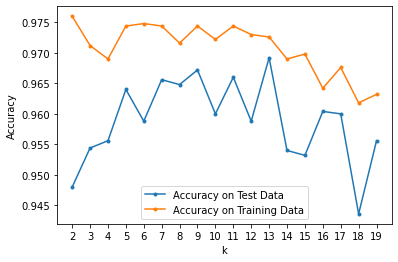

In [40]:
accy = np.array(acc)
stds = np.array(std)/np.sqrt(nreps)
plt.plot(kvals, accy[:, 0], '.-', label = 'Accuracy on Test Data')
plt.plot(kvals, accy[:, 1], '.-', label = 'Accuracy on Training Data')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(kvals)
plt.legend(loc = 'best');
print(f'Max Test Accuracy at k = {kvals[np.argmax(accy[:, 0])]} with accuracy {np.max(accy[:, 0]):.03f}')

Now, it looks llike $k$ = 13 is the best-performing value of the hyperparameter.

Can we be sure?

Be careful!  Each point in the above plot is the mean of 50 random train/test splits!

If we are going to be __sure__ that $k$ = 13 is best, then it should be be statistically distinguishable from the other values.

To make this call, let's plot $\pm 1 \sigma$ confidence intervals on the mean values.

(See the Probability Refresher for details on the proper formula.)

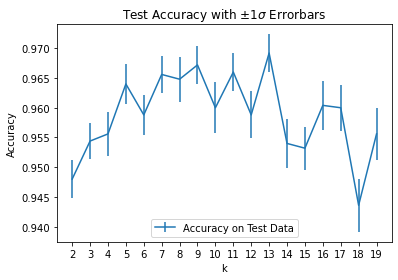

In [41]:
plt.errorbar(kvals, accy[:, 0], stds[:, 0], label = 'Accuracy on Test Data')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower center')
plt.xticks(kvals)
plt.title(r'Test Accuracy with $\pm 1\sigma$ Errorbars');

It looks like $k$ = 13 is a reasonable value,

although a case can be made that 9 and 11 are not statistically distinguishable from 13.

To gain insight onto the complexity of the model for $k$ = 13, let's look at the decision boundary.

Note that we will re-run the classifier using only two (of four) features, so we can visualize.

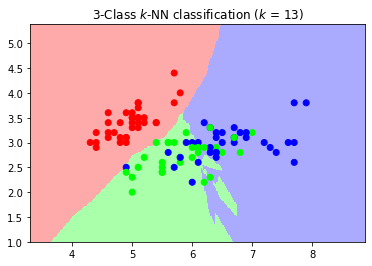

In [42]:
# Create color maps
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# we will use only the first two (of four) features, so we can visualize
X = X_train[:, :2] 
h = .02  # step size in the mesh
k = 13
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X, y_train)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(f"3-Class $k$-NN classification ($k$ = {k})");

There are a few artifacts, but overall this looks like a reasonably smooth set of decision boundaries.

Now we'll compare to a decision tree.

How do we control the complexity of a Decision Tree?

There are a variety of ways (see the `sklearn` documentation) but the simplest one is to control the number of leaf nodes in the tree.  

A small number of leaf nodes is a low-complexity model, and a large number of nodes is a high-complexity model.

In [43]:
X = iris.data
y = iris.target

In [44]:
leaf_vals = range(3, 20)
nreps = 50

acc = []
std = []
np.random.seed(0)
for leaf_count in leaf_vals:
    test_rep = []
    train_rep = []
    for i in range(nreps):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.10)
        dtc = tree.DecisionTreeClassifier(max_leaf_nodes = leaf_count)   
        dtc.fit(X_train, y_train)
        train_rep.append(dtc.score(X_train, y_train))
        test_rep.append(dtc.score(X_test, y_test))
    acc.append([np.mean(np.array(test_rep)), np.mean(np.array(train_rep))])
    std.append([np.std(np.array(test_rep)), np.std(np.array(train_rep))])
accy = np.array(acc)
stds = np.array(std)/np.sqrt(nreps)

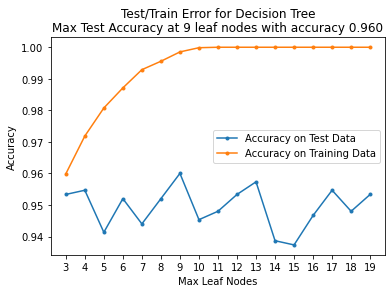

In [45]:
plt.plot(leaf_vals, accy[:, 0], '.-', label = 'Accuracy on Test Data')
plt.plot(leaf_vals, accy[:, 1], '.-', label = 'Accuracy on Training Data')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.xticks(leaf_vals)
best_leaf = leaf_vals[np.argmax(accy[:, 0])]
plt.title(f'Test/Train Error for Decision Tree\nMax Test Accuracy at {best_leaf} leaf nodes with accuracy {np.max(accy[:, 0]):.03f}');

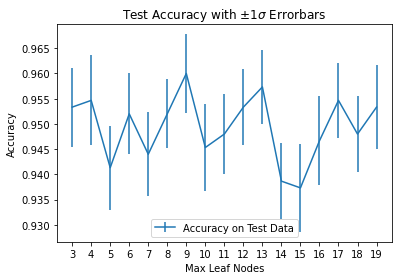

In [46]:
plt.errorbar(leaf_vals, accy[:, 0], stds[:, 0], label = 'Accuracy on Test Data')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower center')
plt.xticks(leaf_vals)
plt.title(r'Test Accuracy with $\pm 1\sigma$ Errorbars');

It looks like 9 leaf nodes is appropriate, but we would be justified to choose 4 or 13 as well.

And now let's visualize the decision boundary for the DT:

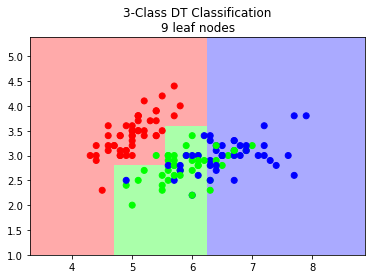

In [47]:
# we will use only the first two (of four) features, so we can visualize
X = X_train[:, :2] 
h = .02  # step size in the mesh
dtc = tree.DecisionTreeClassifier(max_leaf_nodes = best_leaf) 
dtc.fit(X, y_train)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(f"3-Class DT Classification\n{best_leaf} leaf nodes");

### MNIST dataset

NIST used to be called the "National Bureau of Standards."  These are the folks who bring you the reference meter, reference kilogram, etc.

NIST constructed datasets for machine learning of handwritten digits. These were collected from Census Bureau employees and also from high-school students.

These data have been used repeatedly for many years to evaluate classifiers.  For a peek at some of the work done with this dataset you can visit http://yann.lecun.com/exdb/mnist/. 

In [48]:
import sklearn.utils as utils

digits = datasets.load_digits()
X, y = utils.shuffle(digits.data, digits.target, random_state = 1)

print ('Data shape: {}'.format(X.shape))
print ('Data labels: {}'.format(y))
print ('Unique labels: {}'.format(digits.target_names))

Data shape: (1797, 64)
Data labels: [1 5 0 ... 9 1 5]
Unique labels: [0 1 2 3 4 5 6 7 8 9]


An individual item is an $8 \times 8$ image, encoded as a matrix:

In [49]:
digits.images[3]

array([[ 0.,  0.,  7., 15., 13.,  1.,  0.,  0.],
       [ 0.,  8., 13.,  6., 15.,  4.,  0.,  0.],
       [ 0.,  2.,  1., 13., 13.,  0.,  0.,  0.],
       [ 0.,  0.,  2., 15., 11.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1., 12., 12.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1., 10.,  8.,  0.],
       [ 0.,  0.,  8.,  4.,  5., 14.,  9.,  0.],
       [ 0.,  0.,  7., 13., 13.,  9.,  0.,  0.]])

Let's show the matrix as an image:

<Figure size 432x288 with 0 Axes>

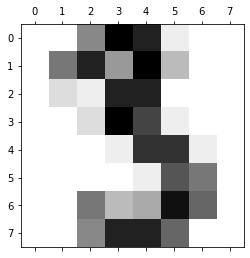

In [50]:
plt.gray() 
# plt.rc('axes', grid = False);
plt.matshow(digits.images[3], cmap = plt.cm.gray_r);

It is easier to visualize if we blur the pixels a little bit.

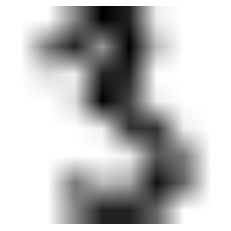

In [51]:
plt.rc('image', cmap = 'binary', interpolation = 'bilinear')
plt.figure(figsize = (4, 4))
plt.axis('off')
plt.imshow(digits.images[3]);

Here are some more samples from the dataset:

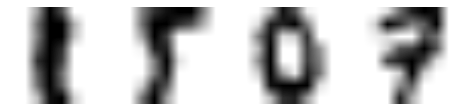

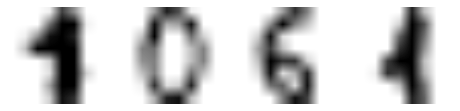

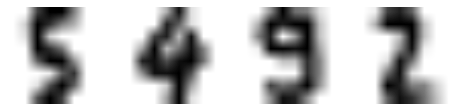

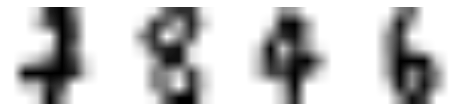

In [52]:
for t in range(4):
    plt.figure(figsize = (8, 2))
    for j in range(4):
        plt.subplot(1, 4, 1 + j)
        plt.imshow(X[4*t + j].reshape(8, 8))
        plt.axis('off');

Although this is an 8 $\times$ 8 image, we can just treat it as a vector of length 64.

To do model selection, we will again average over many train/test splits.

However, recall one issue of $k$-NN: it can be slow on a large training set (why?). 

We may thus decide to limit the size of our testing set to speed up testing.

How does the train/test split affect results?


Let's consider two cases:  
1. Train: 90% of data, Test: 10% of data
2. Train: 67% of data, Test: 33% of data

In [53]:
def test_knn(kvals, test_fraction, nreps):
    acc = []
    std = []
    np.random.seed(0)
    #
    for k in kvals:
        test_rep = []
        train_rep = []
        for i in range(nreps):
            X_train, X_test, y_train, y_test = model_selection.train_test_split(
                X, y, test_size = test_fraction)
            knn = KNeighborsClassifier(n_neighbors = k)    
            knn.fit(X_train, y_train)
            test_rep.append(knn.score(X_test, y_test))
        acc.append(np.mean(np.array(test_rep)))
        std.append(np.std(np.array(test_rep)))
    return(np.array(acc), np.array(std)/np.sqrt(nreps))

test_fraction1 = 0.33
accy1, stds1 = test_knn(range(2, 20), test_fraction1, 50)
test_fraction2 = 0.10
accy2, stds2 = test_knn(range(2, 20), test_fraction2, 50)

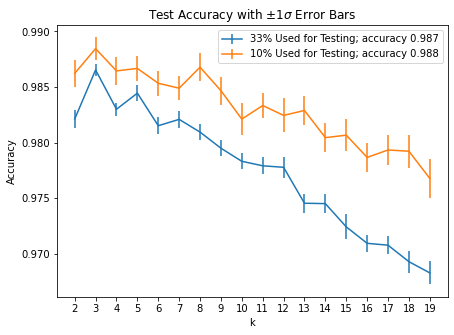

In [54]:
plt.figure(figsize = (7, 5))
plt.errorbar(kvals, accy1, stds1, 
             label = f'{test_fraction1:.0%} Used for Testing; accuracy {np.max(accy1):.03f}')
plt.errorbar(kvals, accy2, stds2, 
             label = f'{test_fraction2:.0%} Used for Testing; accuracy {np.max(accy2):.03f}')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.xticks(kvals)
best_k = kvals[np.argmax(accy1)]
plt.title(f'Test Accuracy with $\pm 1\sigma$ Error Bars');

These plots illustrate important principles:
    
* The more data used for training, the better the classifier will tend to perform
* The less data used for testing, the more variable will be the testing results 
    (but the faster testing will go)
    
    
Note that the key decision here is what value to choose for $k$.   So it makes sense to use the 33% test split, because the smaller error bars give us better confidence in our decision.
   

We can get a sense of why $k$-NN can succeed at this task by looking at the nearest neighbors of some points:

In [55]:
knn = KNeighborsClassifier(n_neighbors = 3)    
knn.fit(X, y)
neighbors = knn.kneighbors(X[:3,:], n_neighbors=3, return_distance=False)

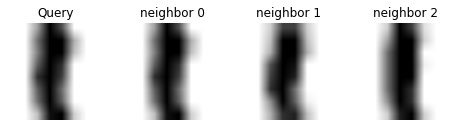

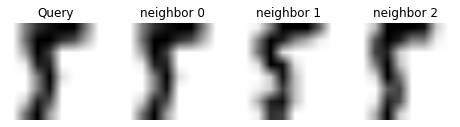

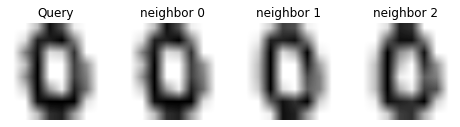

In [56]:
plt.rc("image", cmap="binary")  # this sets a black on white colormap
# plot X_digits_valid[0]
for t in range(3):
    plt.figure(figsize=(8,2))
    plt.subplot(1, 4, 1)
    plt.imshow(X[t].reshape(8, 8))
    plt.axis('off')
    plt.title("Query")
    # plot three nearest neighbors from the training set
    for i in [0, 1, 2]:
        plt.subplot(1, 4, 2 + i)
        plt.title("neighbor {}".format(i))
        plt.imshow(X[neighbors[t, i]].reshape(8, 8))
        plt.axis('off')